# 2025 QC Bootcamp Mini-Project 1, Problem 2
**Authors: Roberto Hernández Palomares & Lara Ismert**

In [67]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.quantum_info import Statevector, Operator
from qiskit import transpile

import matplotlib.pyplot as plt

import numpy as np




Let $U$ be a single-qubit unitary gate and let $n\in \mathbb{N}$. Define the {\em multi-controlled $U$ gate} on a computational basis vector $\ket{x}_n\ket{y}\in \mathbb{C}^{2^n}\otimes \mathbb{C}^2$ by

$$
    (C^nU)\ket{x}_n\ket{y}
    =
    \begin{cases}
    \ket{x}_n U\ket{y} \quad \text{ if }x_i=1 \,\forall i\in [n]\\
    \ket{x}_n \ket{y} \quad \text{ else } 
    \end{cases}.
$$. 

In this mini project, we give two different implementations of the multi-controlled U gate, denoted $C^nU$, using only X, CX, U, H and Toffoli (= combo of Phase change, Hadamards and CX) gates.

Contents: 
- The implementation of $CU$ from Figure 4.6, Nielsen-Chuang.
- The implementation of $C^nU$ from Figure 4.10, Nielsen-Chuang for arbitrary $n$.
- Implementation of strong induction method for $n\in \mathbb{N}$ realizing $C^nU$ with another unitary $V$ such that $V^{2^n-1}=U.$ (it ran all the way to $n=7$ in reasonable time)

Resources:
- *Quantum Computation and Quantum Information*, Nielsen and Chuang (NC).
- *Elementary gates for quantum computation*, Barenco-Bennett-Cleve-DiVicenzo-Margolus-Shor-Sleator-Smolin-Weinfurter (BBCDMSSSW, 1995)
- 2025 QC Bootcamp 1 and 2 Jupyter notebooks

Methods:
1. Our first method is a complete implementation of **Figure 4.10 (NC)**. The main challenge is to decompose CCX (Toffoli) gates and iterate them as their control and target qubits change. Here, we (a) implement $CU$ via Figure 4.6 (NC) and Figure 4.10 (NC) for arbitrary $n$.

2. Our second method seeks to **Generalize Figure 4.8 (NC)** by replacing the Toffoli gates with $C^nX$ gates, as in Lemma 7.5 (BBCDMSSSW). The main challenge is then implementing $C^nX$.

# Method 1: Implementing Figure 4.10 (NC)

**Step 1: Decompose CU**

By Theorem 4.1 and Corollary 4.2 of Nielsen-Chuang, up to a global phase, any unitary $U = U(\phi,\theta,\lambda)$ can be decomposed as $AXBXC$ where $A,B,$ and $C$ are single-qubit gates which satisfy $ABC=I$:
- $A = R_z(\phi)R_y(\theta/2)$
- $B = R_y(-\theta/2)R_z(-(\phi + \lambda)/2)$
- $C = R_z(-(\phi-\lambda)/2)$

Now, one can verify that CU decomposes as $(I\otimes A)\circ CX \circ (I\otimes B) \circ CX \circ (I\otimes B)$, where $I$ represents the identity on 1 qubit (Figure 4.6, NC).

Below, we show this decomposition of $CU$ into single-qubit and CNOT gates.


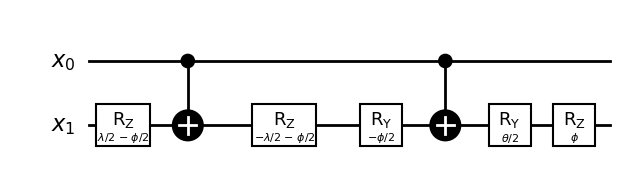

In [2]:

n = 2
cbits = range(0,n-1)

#Parameters which define U

al = Parameter(r"$\alpha$")
theta = Parameter(r"$\theta$")
phi = Parameter(r"$\phi$")
lam = Parameter(r"$\lambda$")


quantum_register = QuantumRegister(n,'x')
cbits = list(range(0,n-1))

Controlled_U_Circuit = QuantumCircuit(quantum_register)

#Controlled_U_Circuit.mcp(al,cbits,n-1) #This would implement the e^(i\alpha) part of U
Controlled_U_Circuit.rz(-(phi-lam)/2,n-1) #Here is C
Controlled_U_Circuit.mcx(cbits,n-1)
Controlled_U_Circuit.rz(-(phi+lam)/2,n-1) #Here is B, part 1
Controlled_U_Circuit.ry(-phi/2,n-1) #Here is B, part 2
Controlled_U_Circuit.mcx(cbits,n-1)
Controlled_U_Circuit.ry(theta/2,n-1) #Here is A, part 1
Controlled_U_Circuit.rz(phi,n-1) #Here is A, part 2

Controlled_U_Circuit.draw(output="mpl", style="bw")


We'll want to be able to tack this $CU$ into a larger register when we implement Figure 4.10, so we define a more general $CU$ gate function below.

In [ ]:
# Controlled U gate on register of arbitrary size n
# and ancilla register of size n-2 (needed for Fig 4.10)

def cu(n,cbit,tbit):
    qr = QuantumRegister(n,'x')
    ar = AncillaRegister(n-2,'a')
    cu_circuit = QuantumCircuit(qr,ar)

    cu_circuit.rz(-(phi-lam)/2,tbit) #Here is C
    cu_circuit.cx(cbit,tbit)
    cu_circuit.rz(-(phi+lam)/2,tbit) #Here is B, part 1
    cu_circuit.ry(-phi/2,tbit) #Here is B, part 2
    cu_circuit.cx(cbit,tbit)
    cu_circuit.ry(theta/2,tbit) #Here is A, part 1
    cu_circuit.rz(phi,tbit) #Here is A, part 2
    
    return cu_circuit

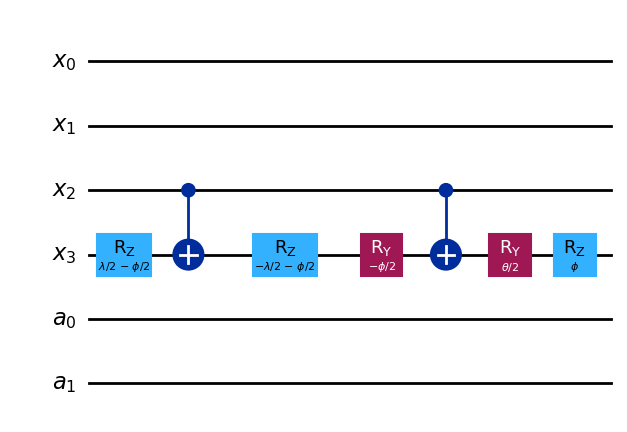

In [17]:

cu(4,2,3).draw(output="mpl")

Now we're ready to proceed with implementing the full **Figure 4.10 from Nielsen-Chuang**.

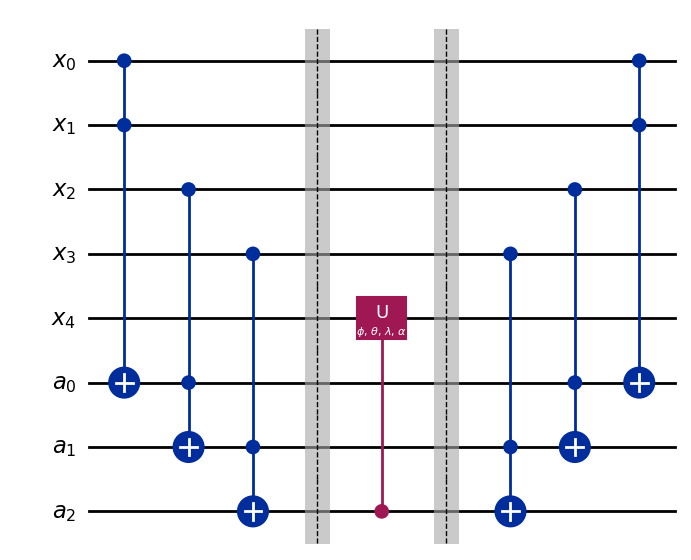

In [60]:
n = 5 #Make sure this n matches the n in the previous code box for 
#the decomposition of the Toffoli (ccx) gate.
tbit = n-1 #last qubit in main register
cbit = -1 #last ancilla qubit

#Parameters defining U
#al = Parameter(r"$\alpha$")
theta = Parameter(r"$\theta$")
phi = Parameter(r"$\phi$")
lam = Parameter(r"$\lambda$")
al = Parameter(r"$\alpha$")

qr = QuantumRegister(n,'x')
ar = AncillaRegister(n-2,'a')



mcu_qc = QuantumCircuit(qr,ar,name = 'Multi-controlled U')

#The first Toffoli gate in Figure 4.10 always has the 0,1 qubits as controls
#and the first ancilla bit (-(n-2)) as the target.

mcu_qc.ccx(0,1,-(n-2)) 
    

#Now we'll apply the iterated Toffoli gates before the controlled U gate.

for i in range(2,n-1):
    mcu_qc.ccx(i,i+(n-2),i+n-1) 

mcu_qc.barrier()

#

#Here we apply U to the last qubit, whose decomposition we will show in a later step.

#Begin controlled U gate #
mcu_qc.cu(phi,theta,lam,al,control_qubit=-1,target_qubit=n-1)
# End controlled U gate##

mcu_qc.barrier()

#Now we'll apply the rest of the iterated Toffoli gates following the controlled U gate.

for i in reversed(range(2,n-1)):
    mcu_qc.ccx(i,i+(n-2),i+n-1) 

#The last Toffoli gate in Figure 4.10 always has the 0,1 qubits as controls
#and the first ancilla bit (-(n-2)) as the target.

mcu_qc.ccx(0,1,-(n-2)) 

mcu_qc.draw(output="mpl")

**Step 2: CCX (Toffoli) with inputs for control bits and target bit**

Because we need to apply iterations of ccx within a register of size $2n-2$ (to allow for an $n-2$-bit ancilla register, as above) where the control bits, c1 and c2, and the target bit, tbit, can be chosen.

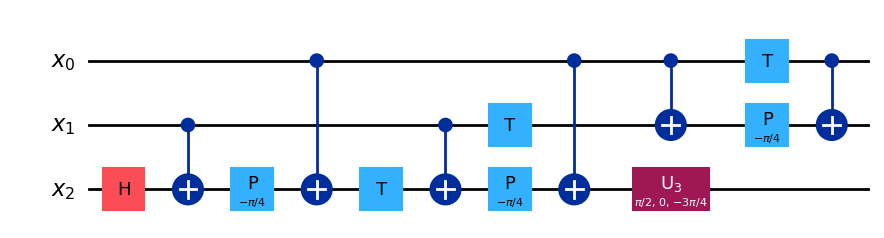

In [25]:
#Decomposition of ccx using transpile

qr = QuantumRegister(3,'x')
qc = QuantumCircuit(qr)

qc.ccx(0,1,2)
decomposed_ccx = transpile(qc, basis_gates=['ry','p','t','s','h','u3','cx'])
decomposed_ccx.draw(output="mpl")

Note that this decomposition of the Toffoli gate has a depth of 11, while a common decomposition of the same gate using only the H, T, Tdg, S, and CX gates as in Figure 4.9 (NC) has a depth of 13. 

Next we define a function for ccx which allows for different sized registers, control bits, and target bit.

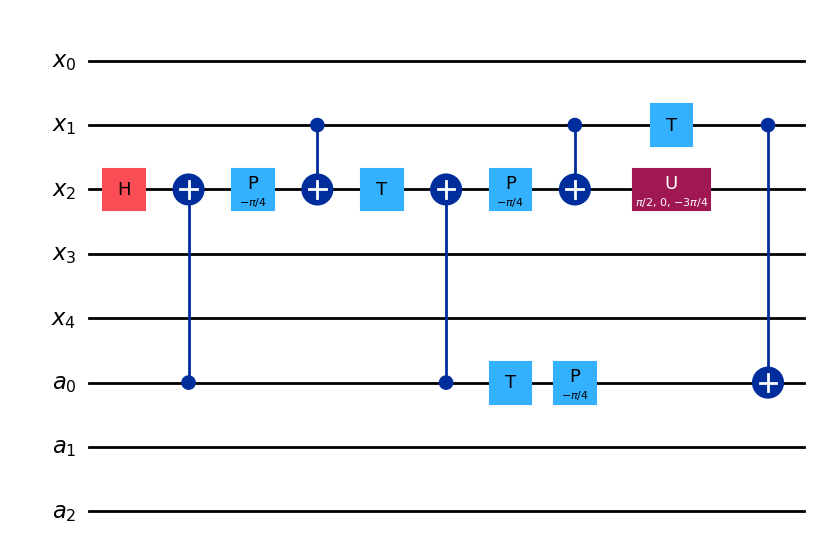

In [61]:
## Here is a decomposition of the Toffoli gate 
# on a 2n-2 qubit register (size needed for next step)

n = 5 #number of bits in quantum register (not including ancilla)
#2n-2 is how many total bits will be in combined register for 
#implementing mcu

c1 = 1 #one of the two control bits
c2 = 5 #one of the two control bits
tbit = 2 #target bit

#This is just copied from transpile of ccx above

def ccx(c1,c2,tbit,n):
    qr = QuantumRegister(n,'x')#qubit register
    ar = QuantumRegister(n-2,'a')#ancilla register
    qc_ccx = QuantumCircuit(qr,ar)

    qc_ccx.h(tbit)
    qc_ccx.cx(c2,tbit)
    qc_ccx.p(-np.pi/4,tbit)
    qc_ccx.cx(c1,tbit)
    qc_ccx.t(tbit)
    qc_ccx.cx(c2,tbit)
    qc_ccx.t(c2)
    qc_ccx.p(-np.pi/4,tbit)
    qc_ccx.cx(c1,tbit)
    qc_ccx.u(np.pi/2,0,-3*np.pi/4,tbit)
    qc_ccx.t(c1)
    qc_ccx.p(-np.pi/4,c2)
    qc_ccx.cx(c1,c2)
    return qc_ccx

ccx(c1,c2,tbit,n).draw('mpl')



We will now use our decomposition of ccx above to implement Figure 4.10 (NC) for $C^nU$ with only single-qubit and CNOT gates. 

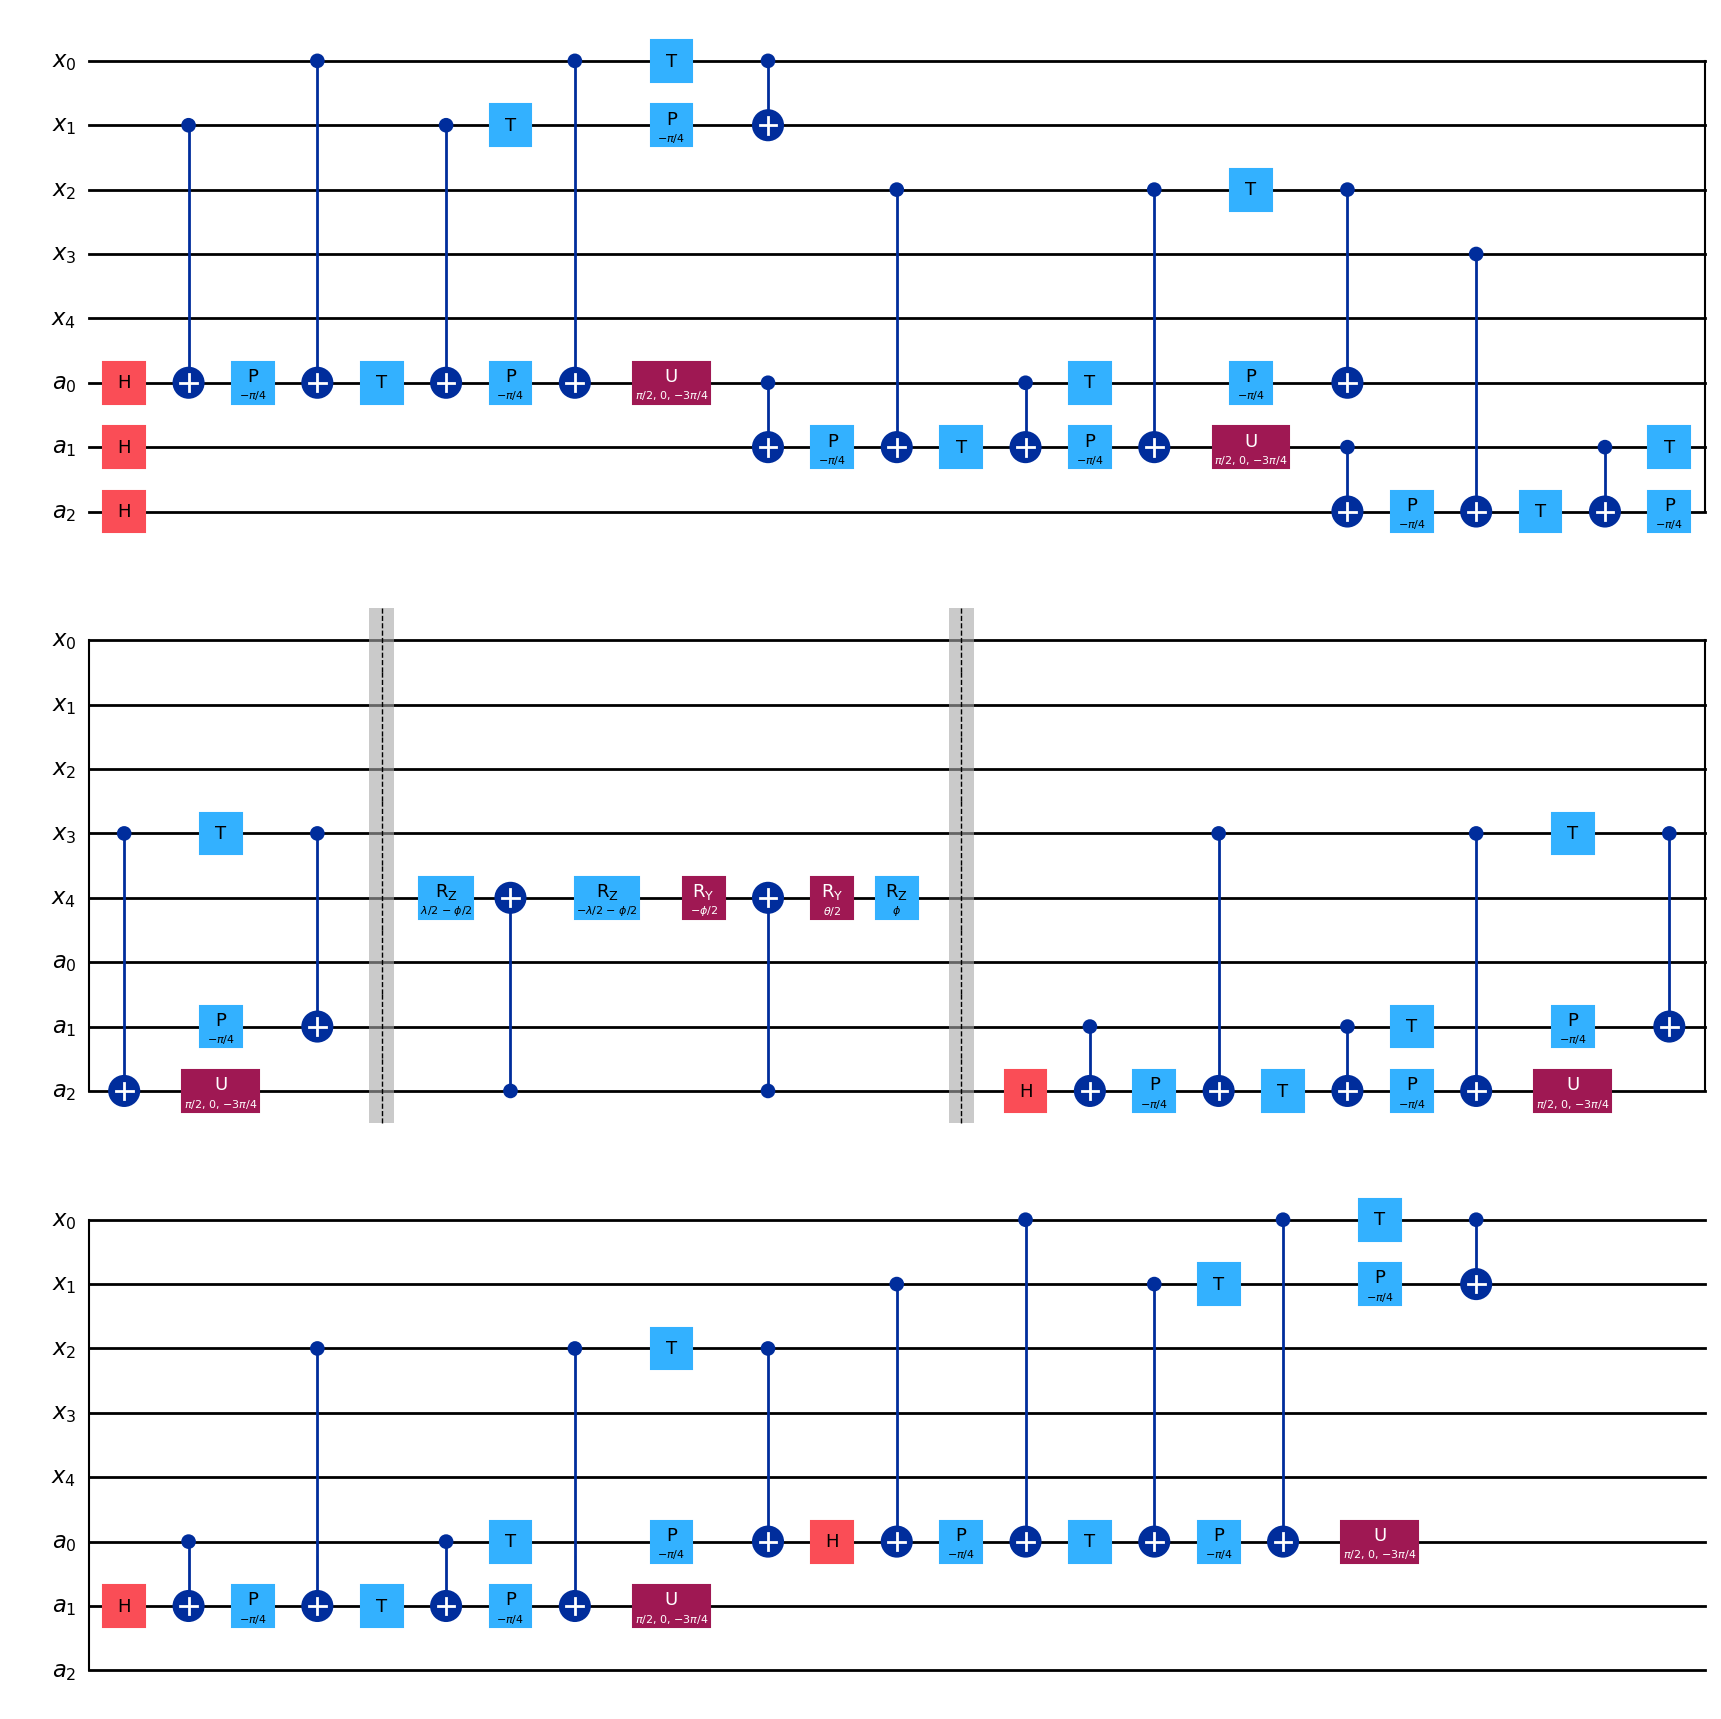

In [64]:
n = 5 #Make sure this n matches the n in the previous code box for 
#the decomposition of the Toffoli (ccx) gate.

al = Parameter(r"$\alpha$")
theta = Parameter(r"$\theta$")
phi = Parameter(r"$\phi$")
lam = Parameter(r"$\lambda$")


qr = QuantumRegister(n,'x')
ar = AncillaRegister(n-2,'a')

mcu_qc = QuantumCircuit(qr,ar,name = 'Multi-controlled X')

#The first Toffoli gate in Figure 4.10 always has the 0,1 qubits as controls
#and the first ancilla bit (-(n-2)) as the target.

    ##Pick one of the following two to uncomment:
mcu_qc.compose(ccx(0,1,-(n-2),n),inplace = True) #Uncomment to decompose ccx
#mcu_qc.ccx(0,1,-(n-2)) #Uncomment to compress ccx
    ##

#Now we'll apply the iterated Toffoli gates before the controlled U gate.

for i in range(2,n-1):
        ##Pick one of the following two to uncomment:
    mcu_qc.compose(ccx(i,i+(n-2),i+(n-1),n),inplace = True) #Uncomment to decompose ccx
    #mcu_qc.ccx(i,i+(n-2),i+(n-1)) #Uncomment to compress ccx
        ##

mcu_qc.barrier()

#Here we have U decomposed using Figure 4.6 (code written earlier).

#Begin controlled U gate #
mcu_qc.rz(-(phi-lam)/2,n-1)
mcu_qc.cx(-1,n-1)
mcu_qc.rz(-(phi+lam)/2,n-1)
mcu_qc.ry(-phi/2,n-1)
mcu_qc.cx(-1,n-1)
mcu_qc.ry(theta/2,n-1)
mcu_qc.rz(phi,n-1)
# End controlled U gate#

mcu_qc.barrier()

#Now we'll apply the rest of the iterated Toffoli gates following the controlled U gate.

for i in reversed(range(2,n-1)):
        ##Pick one of the following two to uncomment:
    mcu_qc.compose(ccx(i,i+(n-2),i+(n-1),n),inplace = True) #Uncommenting decomposes ccx
    #mcu_qc.ccx(i,i+(n-2),i+n-1) #Uncommenting compresses ccx
        ##

#The last Toffoli gate in Figure 4.10 always has the 0,1 qubits as controls
#and the first ancilla bit (-(n-2)) as the target.

    ##Pick one of the following two to uncomment:
mcu_qc.compose(ccx(0,1,-(n-2),n),inplace = True) #Uncommenting this decomposes ccx
#mcu_qc.ccx(0,1,-(n-2)) #Uncommenting this compresses ccx
    ##

mcu_qc.draw(output="mpl")

In [65]:
print("Circuit depth:", mcu_qc.depth())

Circuit depth: 63


# Complexity

Each ccx gate in our implementation has a depth of 10 when decomposed into single-qubit and CNOT gates, and each mcu(n) requires $2(n-2)$ ccx gates. Additionally, our mcu gate includes one CU gate whose depth is 5, so in total, the depth of our mcu circuit on an $n$-qubit register is (at most)
$$
5*1 + 11*2(n-2) = 5+ 22(n-2).
$$
When $n=3$, the depth is exactly $5+22(3-2) = 27$, but for larger values of $n$, the depth is a bit less than $5+22(n-2)$ due to consecutive gates being able to be run simultaneously.

Therefore, for $C^nU$ the time complexity is linear in $n$, as is the resource complexity (requiring $n$ qubits and $n-2$ ancilla).

# Method 2: Generalizing Figure 4.6 using $C^nX$

**Step 1: Strong induction method**

From the paper *Elementary gates for quantum computation* by Barenco et al, we picked an idea from the identity displayed on page 18:

$$
\sum_{k_1}x_{k_1} - \sum_{k_1<k_2}(x_{k_1}\oplus x_{k_1}) + \sum_{k_1<k_2<k_3}(x_{k_1}\oplus x_{k_2}\oplus x_{k_3})-\cdots +(-1)^{n-1}(x_1\oplus x_2\oplus\cdots\oplus x_n) =  2^{n-1}(x_1\cdot x_2\cdot \cdots \cdot x_n).
$$

The right-hand side is (a multiple of) a gate that only opens whenever all the boolean entries equal one simultaneously; i.e. corresponds to $C^n{U}$. Let $V$ be another unitary satisfying $V^{2^{n-2}}=U$. The identity above tells us precisely how to express this opening condition on $n$ boolean variables in terms of all other combinations of $C^kV$ and $C^kV^\dagger$ depending on parity, for $k=0,1,...,m-1$ applied over all $k$ elements subsets of the variables.

We notice this is rather inefficient, however it gets the job done. For the most part, we only care about $U = X$.


To implement this expression we prepare a couple of functions in order to be able to iterate over all $m$-elements ordered increasing subsets of $1, 2, ..., N$ corresponding to the indices of the sums. 

In [33]:
def SumMod2_Tuple (K, m): #sums Mod 2 over entries of m-tuple K
    sum = 0 
    for i in range(0, m):
        sum = (sum + K[i])%2
    return sum

def Inc_K (K, m): # Verifies if given m-tuple is strictly increasing
    val = True
    for i in range(m-1):
        if K[i] >= K[i+1]:
            val = False
            return val
    return val

def m_DimArray(m):  # Creates an m-dimensional array to parameterize all values of i_1, ... i_m
    L = [1]
    for i in range(m):
        L = [L]*m
        return L

The following function ranges over all $k$-element increasing ordered subsets of $\{i:1i\leq i\leq N\}$:

In [34]:
### This function ranges over al k-element increasing ordered subsets of N
import itertools  # This helps iterating loops over complex parameter spaces

N = 3
for m in range(1,N+1):#ranging over the degree of monomials
    shape = [N]*m
    for iK in itertools.product(*[range(s) for s in shape]):
        if Inc_K(iK, m): #Inc_K verifies condition   
            iK = [iK[i] + ([1]*(len(iK)))[i] for i in range(len(iK))]
            print('iK=', iK)

iK= [1]
iK= [2]
iK= [3]
iK= [1, 2]
iK= [1, 3]
iK= [2, 3]
iK= [1, 2, 3]


**Step 2: Implement $C^nX$, or more generally, $C^nU$** 

We now loop over all these subsets and add a $k$-controlled X gate for each. Note that the controlled $U$ gates below are actually supposed to represent controlled $V$ and $V^\dagger$ gates where $V$ is a unitary satisfying $V^{2^{n-2}}=U$.

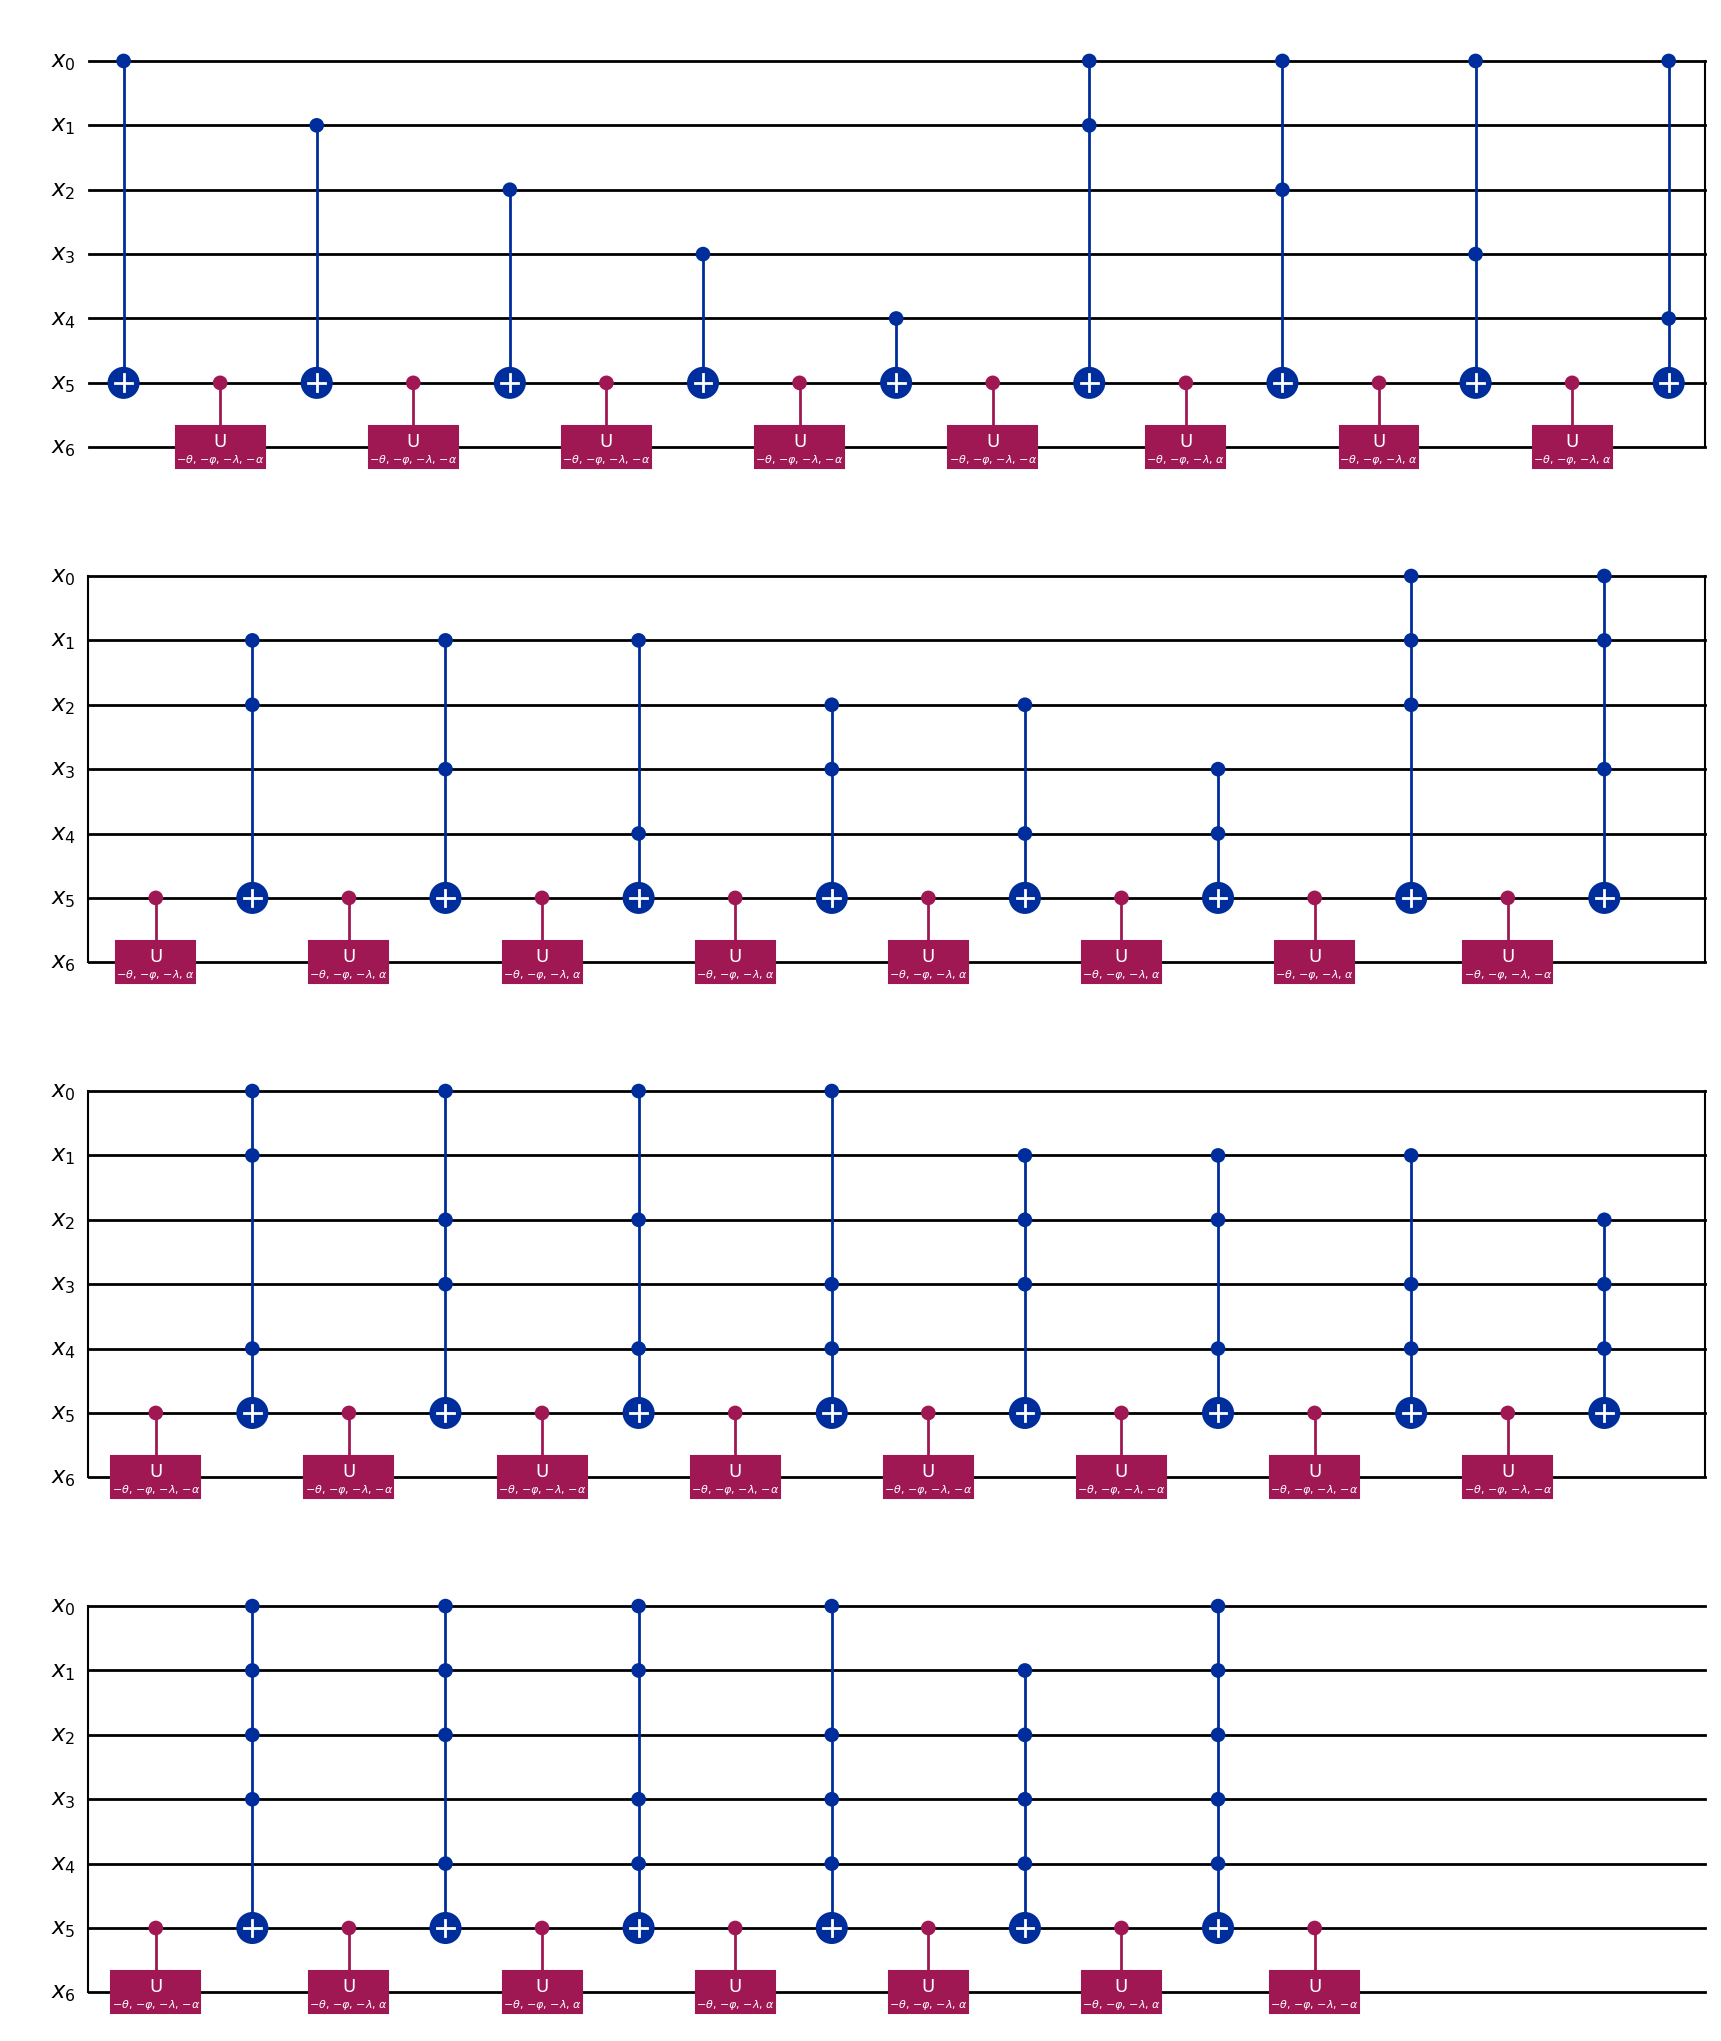

In [52]:
N = 5
Alpha = Parameter(r"$\alpha$")
Delta = Parameter(r"$\delta$")
Gamma = Parameter(r"$\gamma$")
Theta = Parameter(r"$\theta$")
Phi = Parameter(r"$\varphi$")
Lambda = Parameter(r"$\lambda$")

Bar_qr = QuantumRegister(N+2,'x')
Bar_qc = QuantumCircuit(Bar_qr)
Bar_bits = list(range(0, N))
Beta = Parameter('$\beta$')

for m in range(1,N+1):#ranging over the degree of monomials
    shape = [N]*m
    for iK in itertools.product(*[range(s) for s in shape]):
        if Inc_K(iK, m): #Inc_K verifies condition   
            #print(list(iK))
            Bar_qc.mcx(list(iK),N)##Alternating with CV and CV^\dag depending on m%2. At the ends this gives V^{2^{m-1}x_1x_2...x_N} = U
            if (m%2==0):
                Bar_qc.cu(-Theta, -Phi, -Lambda, Alpha, control_qubit=N, target_qubit=N+1)#not sure what alpha is doing. compiler asked for xtra parameter
            else: 
                Bar_qc.cu(-Theta, -Phi, -Lambda, -Alpha, control_qubit=N, target_qubit=N+1)#not sure what alpha is doing. compiler asked for xtra parameter
Bar_qc.draw(output='mpl')


In [53]:
print("Circuit depth:", Bar_qc.depth())

Circuit depth: 62


Remaining steps would include a method for finding $2^{n-2}$-roots of $U$ to play the role of $V$.

# Complexity

Although this implementation of $C^nU$ will have a much larger depth than the previous method we employed, it requires only one ancilla bit (the second from the bottom in the above compilation). The trade-off, then, is time for resources. 
